In [1]:
import alias
import alias.injection as inj
import alias.continuum_normalization as cn

import matplotlib.pyplot as plt
import scipy.signal

import numpy as np
from astropy.io import fits

import random as rand

import tqdm.autonotebook as tqdm

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/alias/injection.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
with open('../data/sample_star_urls_rev2', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra_rev2/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/alias/__init__.py:57: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2


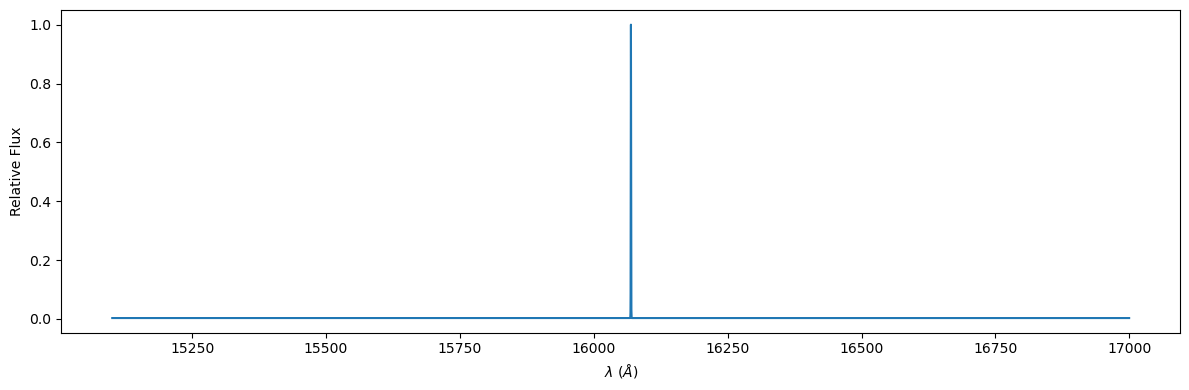

In [3]:
# Plot sample laser signature

lsf = inj.default_lsf

test_laser_signature = np.interp(np.array(range(len(ds.wave)))-4500, lsf.x, lsf.y)

plt.figure(figsize=(12,4))

plt.plot(ds.wave, test_laser_signature)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

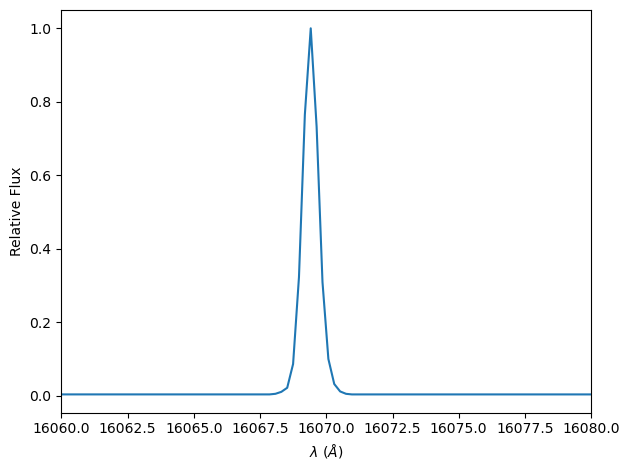

In [4]:
# Zoom in on signature

plt.plot(ds.wave, test_laser_signature)

plt.xlim(16060, 16080)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

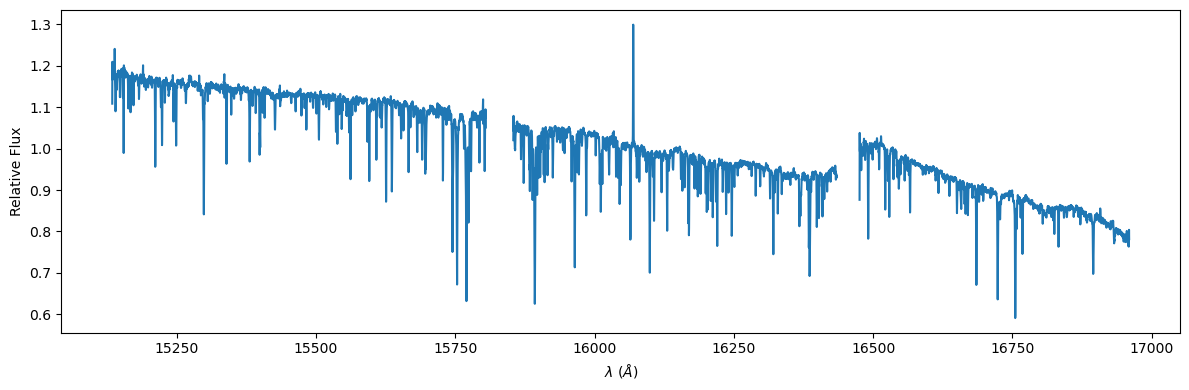

In [5]:
# Inject the signature

flux_injected = ds.flux[101] + 0.3 * test_laser_signature
ivar_injected = ds.ivar[101]

plt.figure(figsize=(12,4))

plt.plot(ds.wave, flux_injected)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

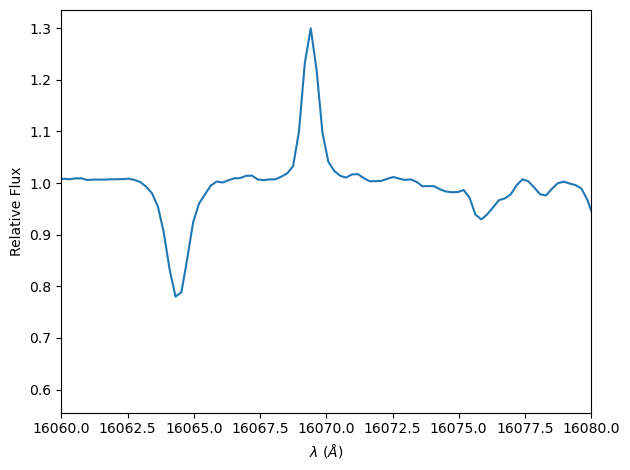

In [6]:
# Zoom in on signature again

plt.plot(ds.wave, flux_injected)

plt.xlim(16060, 16080)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


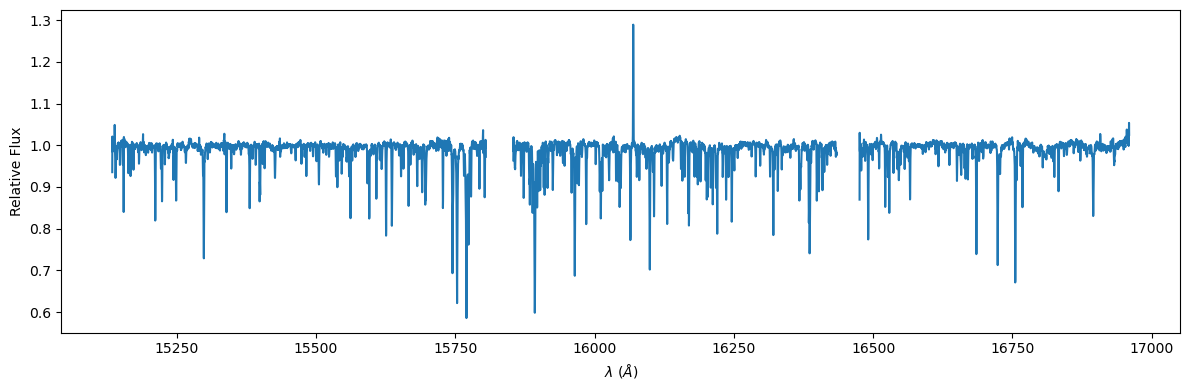

In [7]:
# Now start the detection process

# Continuum normalize the spectrum

flux_injected_norm, ivar_injected_norm, _ = cn.continuum_normalize((flux_injected, ), (ivar_injected))
flux_injected_norm = flux_injected_norm[0]
ivar_injected_norm = ivar_injected_norm[0]

plt.figure(figsize=(12,4))

plt.plot(ds.wave, flux_injected_norm)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

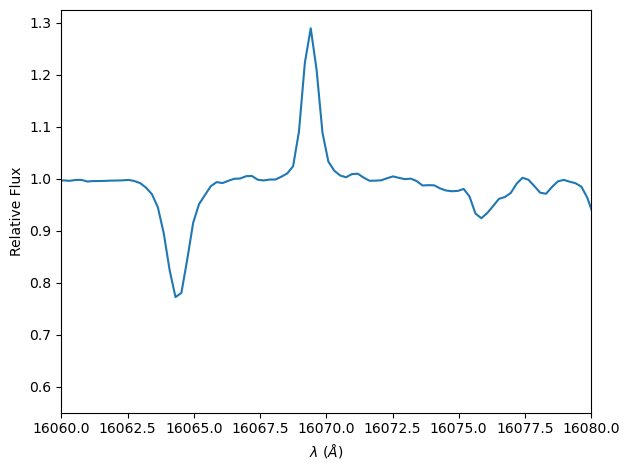

In [8]:
plt.plot(ds.wave, flux_injected_norm)

plt.xlim(16060, 16080)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

In [9]:
peaks = scipy.signal.find_peaks(flux_injected_norm, height = 1.1)[0]

recovered_wavelength = ds.wave[peaks[0]]
recovered_flux = flux_injected_norm[peaks[0]] - 1

print('Recovered Wavelength: %s' %recovered_wavelength)
print('Recovered Amplitude: %s' %recovered_flux)

Recovered Wavelength: 16069.412530128788
Recovered Amplitude: 0.2890089598452805


In [10]:
print('Delta lambda: %s' %(recovered_wavelength - ds.wave[4500]))
print('Delta flux: %s' %(recovered_flux - 0.3))

Delta lambda: 0.0
Delta flux: -0.010991040154719467


In [11]:
# Implement Injection Testing Framework

def create_laser_signature(wave, lsf, idx):
    line = np.interp(np.array(range(len(wave)))-idx, lsf.x, lsf.y)
    return line

def injection_test(ds, lsf, detector, count, min_amp, max_amp):
    results = []

    for i in range(count):
        
        spec = rand.randrange(len(ds.flux))
        valid_idx = np.nonzero(~np.isnan(ds.flux[spec]))[0]
        idx_int = np.random.choice(valid_idx)
        idx = idx_int + np.random.uniform(-0.5, 0.5)
        wave = np.interp(idx, range(len(ds.wave)), ds.wave)
        amp = np.random.uniform(min_amp, max_amp)

        nflux = np.copy(ds.flux[spec])
        nflux += create_laser_signature(ds.wave, lsf, idx)*amp
        
        detections = detector(ds.wave, nflux, ds.ivar[spec])

        if len(detections) == 0:
            results.append((spec, idx, amp, 0, 0, 0, 0))
            continue

        detection_wavelengths = detections[:,0]
        detection_amplitudes = detections[:,1]

        detec_id = np.argmin(np.abs(detection_wavelengths - wave))
        delta_wave = detection_wavelengths[detec_id] - wave

        if np.abs(delta_wave) > 1:
            results.append((spec, idx, amp, 0, 0, 0, len(detections)))
            continue
        
        delta_flux = detection_amplitudes[detec_id] - amp
        results.append((spec, idx, amp, 1, delta_wave, delta_flux, len(detections) - 1))

    return np.array(results, dtype=float)

# Result structure: Spectrum id, injected wavelength, injected flux, detected?, delta wavelength, delta flux, num other detections
        

In [12]:
# Run detector

median_flux = np.nanmedian(cn.continuum_normalize(ds.flux, ds.ivar)[0], axis=0)

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


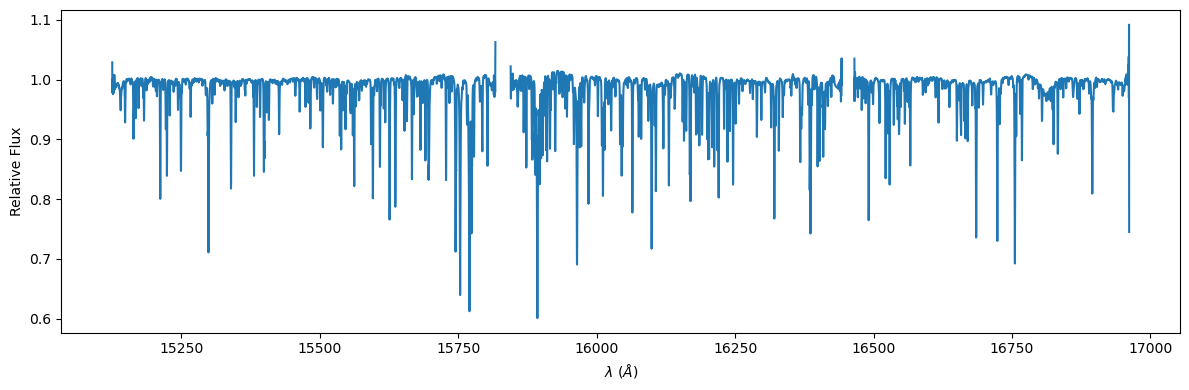

In [13]:
plt.figure(figsize=(12,4))

plt.plot(ds.wave, median_flux, label='Median Continuum-Normalized Spectrum')

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

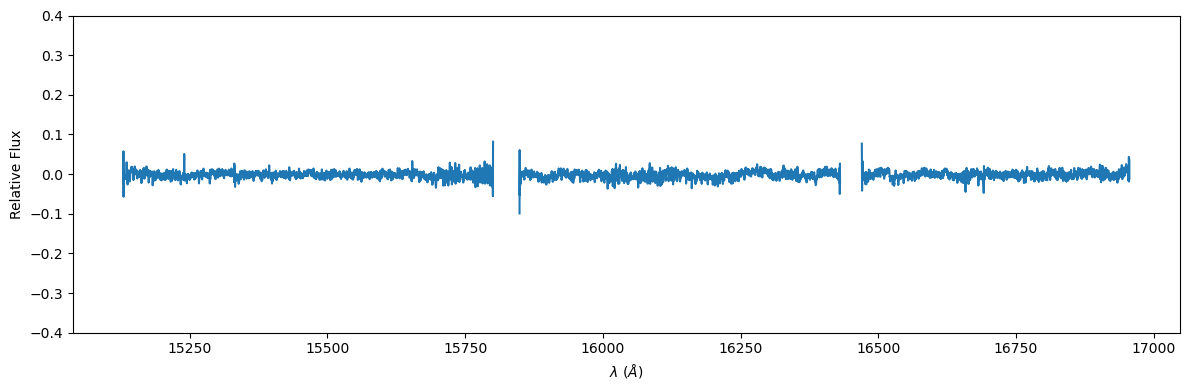

In [14]:
n = 5
f_residual = cn.continuum_normalize((ds.flux[n], ), (ds.ivar[n]))[0][0] - median_flux

plt.figure(figsize=(12,4))

plt.plot(ds.wave, f_residual, label='Median Continuum-Normalized Spectrum')
plt.ylim(-0.4, 0.4)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

plt.tight_layout()

In [15]:
def test_detector(wave, flux, ivar):
        
    flux_norm_res = cn.continuum_normalize((flux, ), (ivar))[0][0] - median_flux
    peaks = scipy.signal.find_peaks(flux_norm_res, height = 0.05)[0]
    wavelengths = wave[peaks]
    amplitudes = flux_norm_res[peaks]
    return np.array((wavelengths, amplitudes)).T

In [16]:
results = injection_test(ds, inj.default_lsf, test_detector, 5000, 0.01, 0.5)

In [17]:
# Now interpret results

print('Efficiency: %s%%' %(100*sum(results[:,3])/len(results)))
print('Other Detections: %s/spectrum' %np.mean(results[:,6]))

Efficiency: 91.12%
Other Detections: 36.2144/spectrum


In [18]:
def show_result(ds, lsf, detector, result):    
    plt.figure(figsize=(12,4))
    spec = int(result[0])
    flux_inj = ds.flux[spec] + create_laser_signature(ds.wave, lsf, result[1]) * result[2]
    wave = np.interp(result[1], range(len(ds.wave)), ds.wave)

    detections = detector(ds.wave, flux_inj, ds.ivar[spec])
    
    plt.plot(ds.wave, flux_inj, label='Injected Spectrum')
    plt.plot(ds.wave, ds.flux[spec], label='Original Spectrum')
    plt.scatter(detections[:,0], detections[:,1] + 1)

    plt.xlim(wave - 15, wave + 15)
        
    plt.xlabel(r'$\lambda$ ($\AA$)')
    plt.ylabel(r'Relative Flux')
    
    plt.tight_layout()

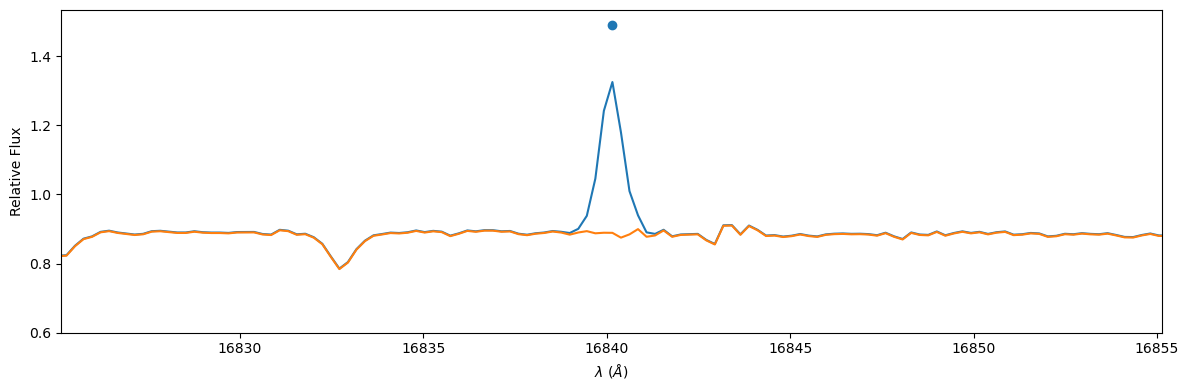

In [19]:
show_result(ds, inj.default_lsf, test_detector, results[22])

Text(0, 0.5, 'Number of Detections')

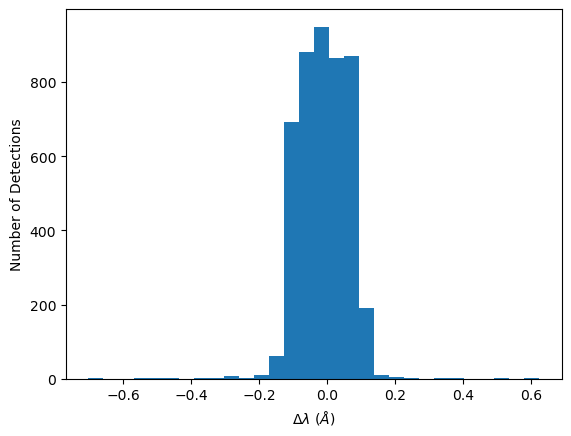

In [20]:
_ = plt.hist(results[results[:,3] > 0.5,4], bins=30)

plt.xlabel('$\Delta\lambda$ ($\AA$)')
plt.ylabel('Number of Detections')

Text(0, 0.5, 'Number of Detections')

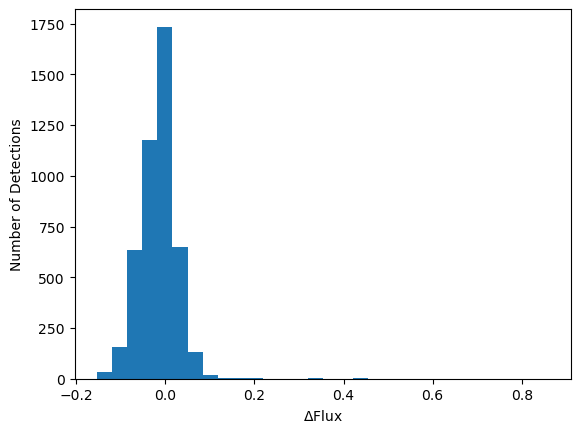

In [21]:
_ = plt.hist(results[results[:,3] > 0.5,5], bins=30)

plt.xlabel('$\Delta$Flux')
plt.ylabel('Number of Detections')

Text(0, 0.5, 'Efficiency (%)')

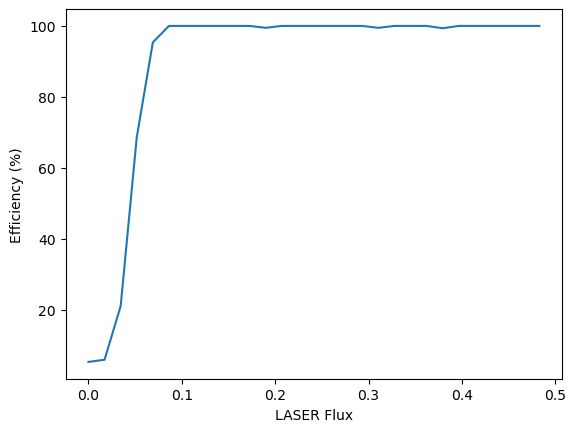

In [22]:
bins = np.linspace(0, 0.5, 30)
all = np.histogram(results[:,2], bins=bins)[0]
detected = np.histogram(results[results[:,3] > 0.5,2], bins=bins)[0]

plt.plot(bins[:-1], 100*detected/all)

plt.xlabel('LASER Flux')
plt.ylabel(r'Efficiency (%)')

/tmp/ipykernel_2110605/3011860377.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins[:-1], detected/all)


Text(0, 0.5, 'Efficiency (%)')

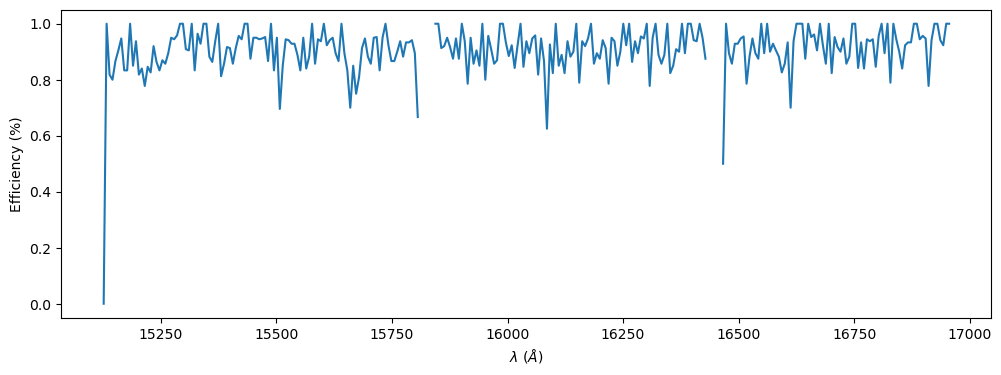

In [23]:
plt.figure(figsize=(12,4))
bins = np.linspace(np.min(ds.wave), np.max(ds.wave), 300)
all = np.histogram(ds.wave[np.array(results[:,1], dtype=int)], bins=bins)[0]
detected = np.histogram(ds.wave[np.array(results[results[:,3] > 0.5,1], dtype=int)], bins=bins)[0]

plt.plot(bins[:-1], detected/all)

plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel(r'Efficiency (%)')

Text(0, 0.5, '$\\Delta\\lambda$ ($\\AA$)')

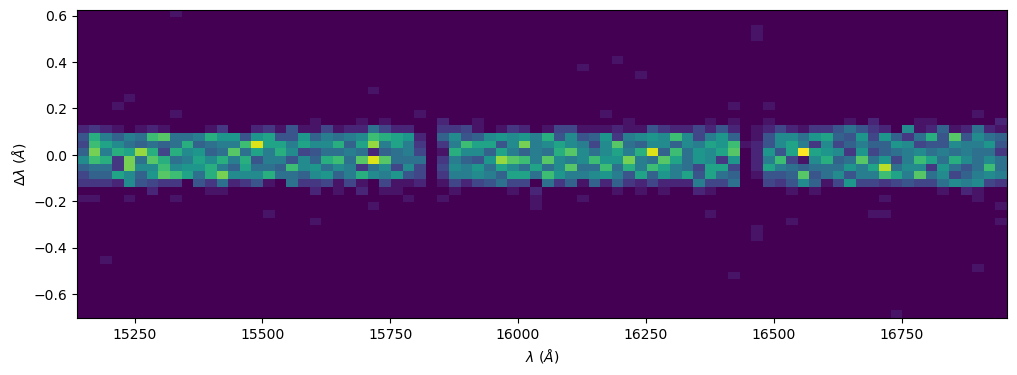

In [24]:
plt.figure(figsize=(12,4))
plt.hist2d(ds.wave[np.array(results[results[:,3] > 0.5,1],dtype=int)], results[results[:,3] > 0.5,4], bins=(80, 40))
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('$\Delta\lambda$ ($\AA$)')

Text(0, 0.5, '$\\Delta\\lambda$ ($\\AA$)')

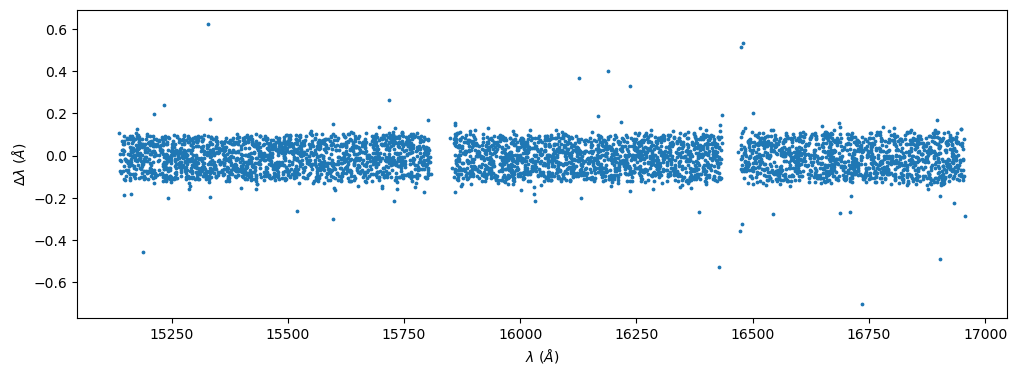

In [25]:
plt.figure(figsize=(12,4))
plt.scatter(ds.wave[np.array(results[results[:,3] > 0.5,1],dtype=int)], results[results[:,3] > 0.5,4], s=3)
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('$\Delta\lambda$ ($\AA$)')